# Saguache County Water Study
Cammie Newmyer

The Saguache County Water Study is a data project that combines well completion reports from the Colorado Division of Water Resources well permit site with input from a master water contractor. The data has been carefully prepared, cleaned, and engineered to create a high-quality dataset suitable for training a deep learning model. This study aims to provide valuable insights into water resources in Saguache County, Colorado, and contribute to informed decision-making and sustainable water management practices. https://dwr.state.co.us/Tools/WellPermits

The dataset used in the Saguache County Water Study contains several key features that have been engineered and prepared for analysis and modeling. These features provide important information related to well completion reports and water resources in Saguache County. 

Feature Descriptions:
    Township_N: This feature represents the township location of the well in Saguache County, providing a geographical reference point.
    Range_E: The range feature indicates the range location of the well within Saguache County, helping to narrow down the well's specific area.
    Section: This feature denotes the section number where the well is located within the township and range, providing more precise spatial information.
    Well_Depth: This feature specifies the depth of the well, indicating how deep the well reaches into the ground to access the water source.
    Elevation_Of_Clay_Layer: If reaching the smectite clay layer is likely, then the depth to the aquifer is calculated using the difference between the elevation of the location of the well and the depth at which the smectite clay layer is reached.
    Smectite_Clay_Layer: This is the target feature for the model. A value of 1 indicates that the smectite clay layer is likely at this location. A value of 0 indicates it is not likely.
    Depth_to_Aquifer: This feature is given by well completion reports identifying blue clay or alternatively when the data is not available expert opinion on the depth of the smectite clay layer in that area.
    Elevation: The elevation feature represents the elevation of the surface of the well, which can be crucial in understanding the vertical positioning of the water source.

# Data Preparation
Import packages for analysis and visualization.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount('/drive/')

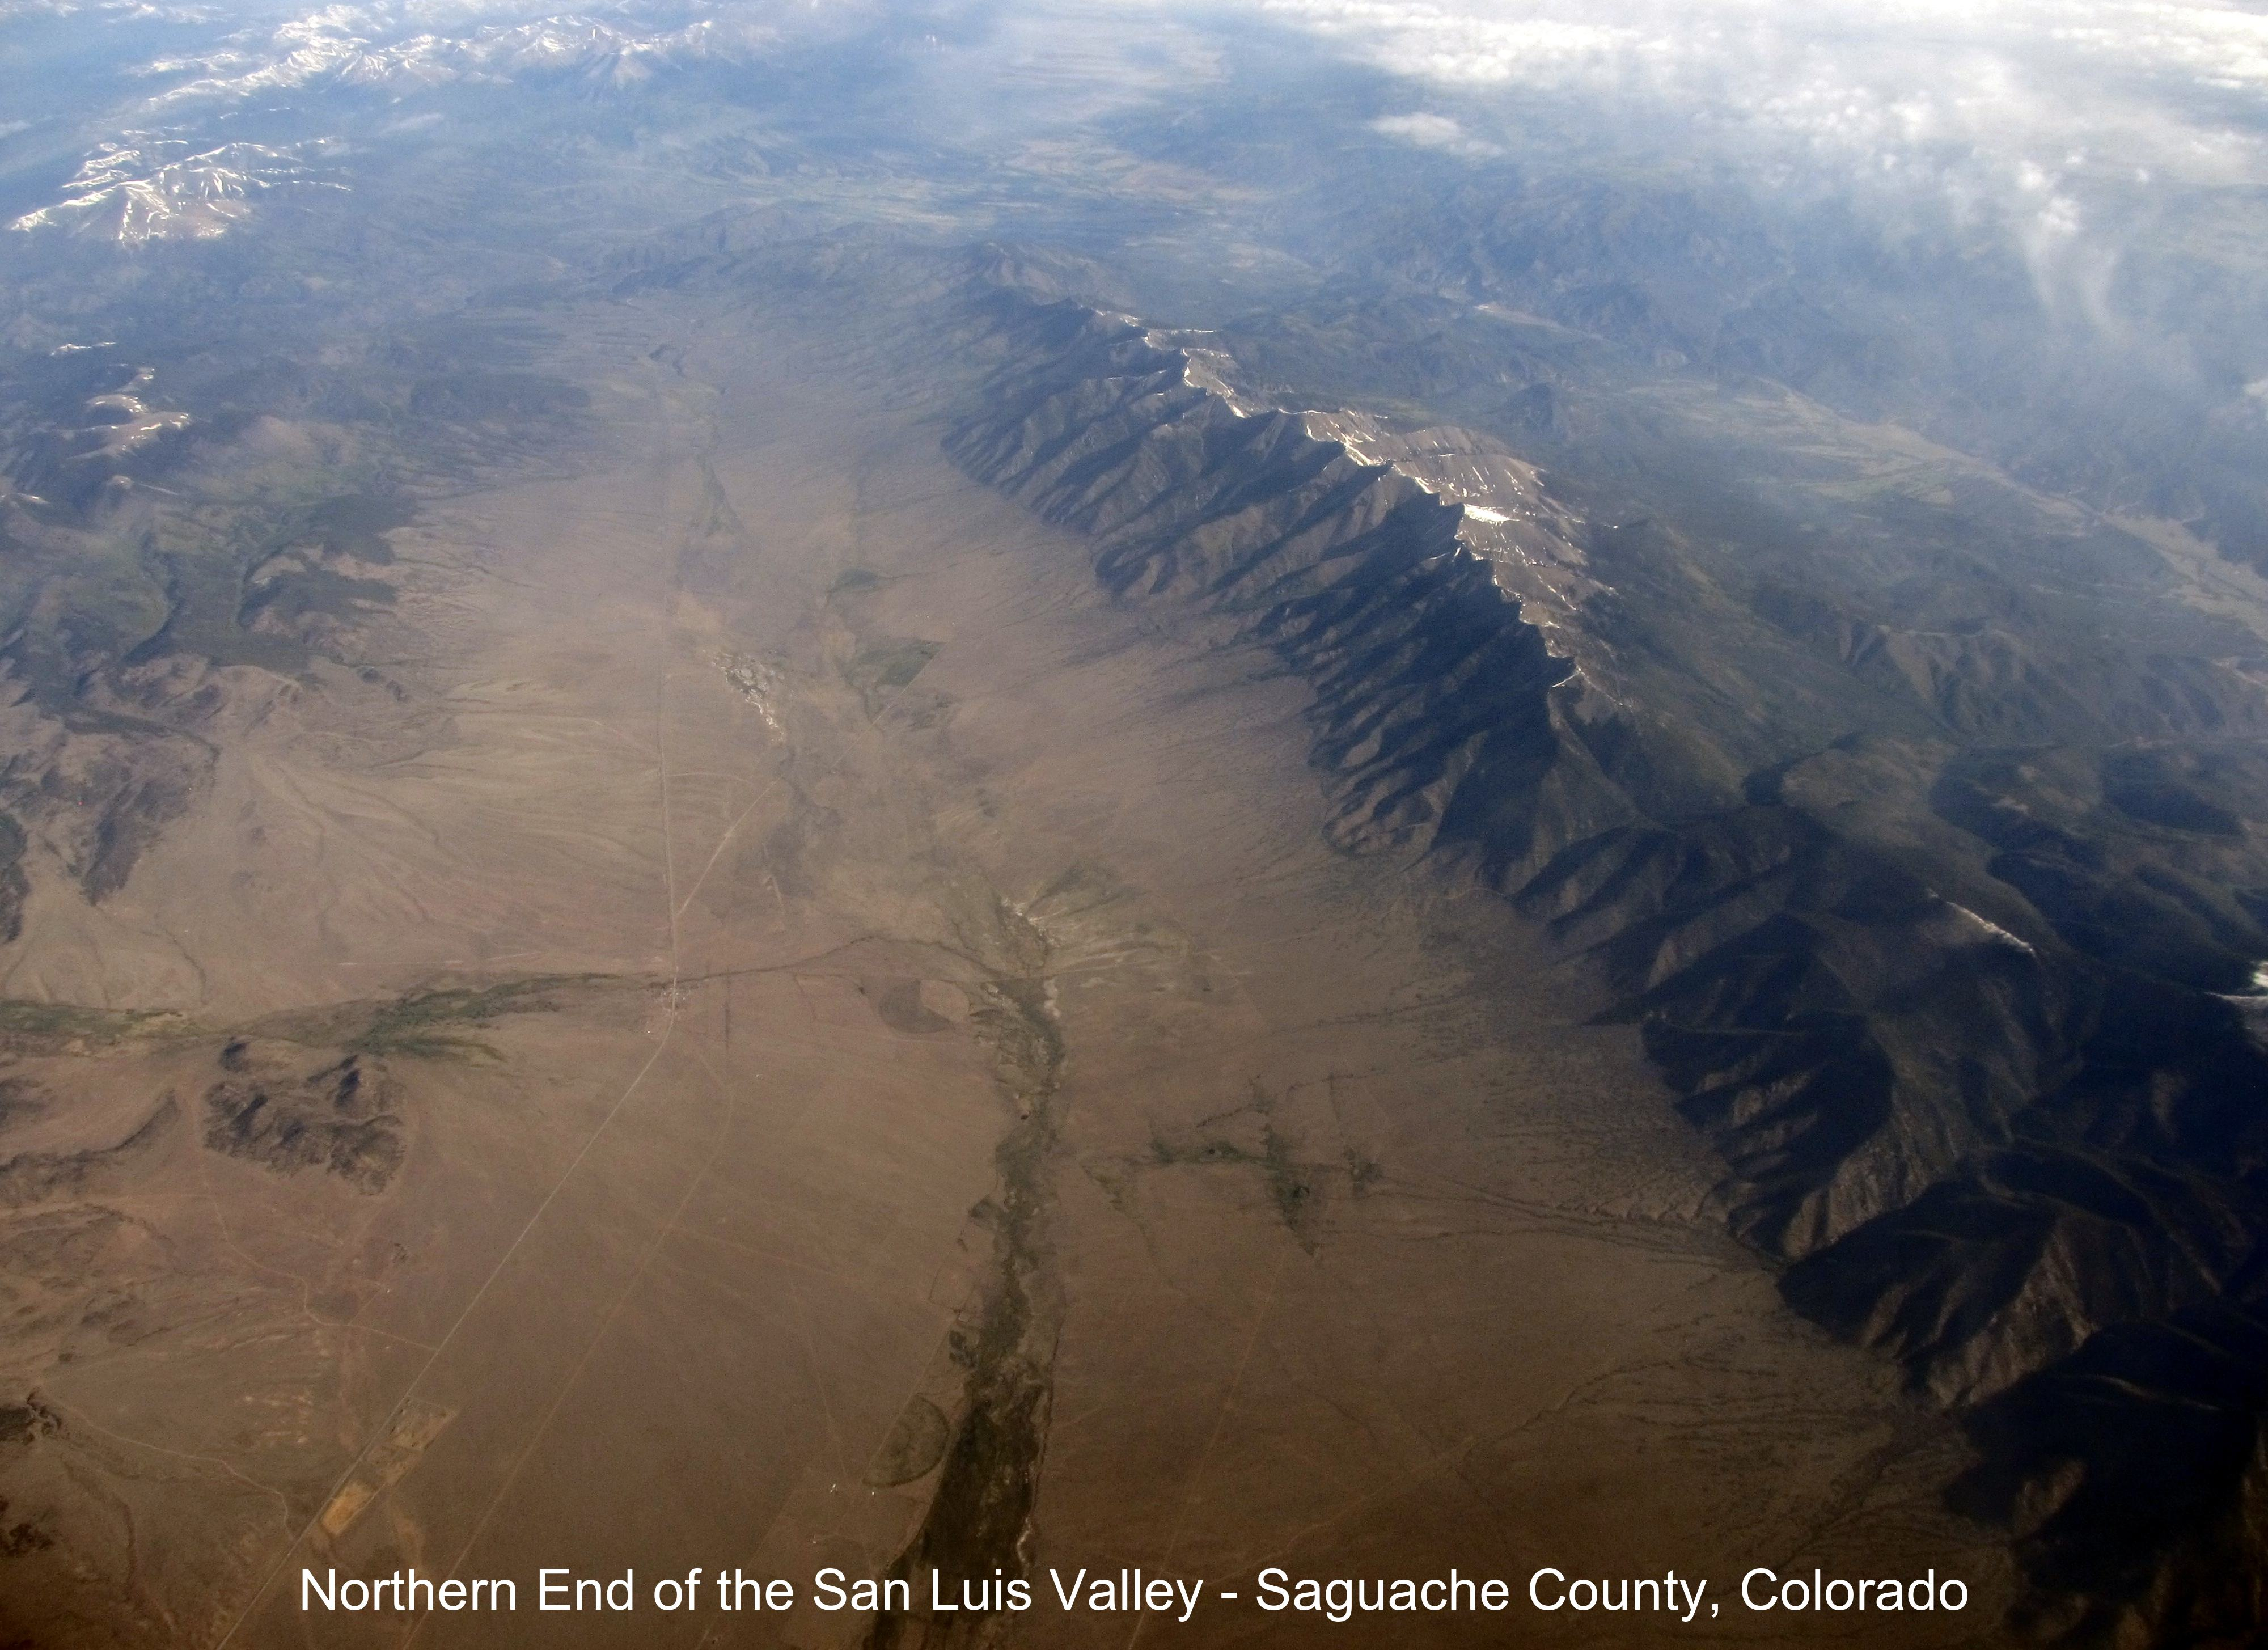

In [2]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as DisplayImage, display

# Open the image
image_path = 'C:/Users/newmy/Desktop/WaterProj/iNorthern_End_of_San_Luis_Valley,_Colorado_(7235128470).jpg'
image = Image.open(image_path)

# Create an ImageDraw object
draw = ImageDraw.Draw(image)

# Define the font and font size
font = ImageFont.truetype("arial.ttf", size=100)

# Define the text to be annotated
text = "Northern End of the San Luis Valley - Saguache County, Colorado"

# Calculate the position to place the text
text_width, text_height = draw.textsize(text, font=font)
x = (image.width - text_width) // 2
y = image.height - text_height - 50

# Set the color of the text
text_color = (255, 255, 255)  # White color

# Annotate the image with the text
draw.text((x, y), text, fill=text_color, font=font)

# Save the annotated image
annotated_image_path = 'C:/Users/newmy/Desktop/WaterProj/annotated_image.jpg'
image.save(annotated_image_path)

# Display the annotated image
display(DisplayImage(filename=annotated_image_path))

# Exploratory Data Analysis

In [3]:
# Read the data and verify input
data = pd.read_csv('C:/Users/newmy/Desktop/WaterProj/dWaterProjDataB.csv')
data

Township_N  Range_E  Section  Well_Depth  Elevation_Of_Clay_Layer  \
0            42        7        1           0                     7700   
1            42        7        2           0                     7700   
2            42        7        3           0                     7700   
3            42        7        4           0                     7700   
4            42        7        5           0                     7700   
..          ...      ...      ...         ...                      ...   
981          69        0        0         991                     7270   
982          69        0        0         400                     7270   
983          69        0        0         620                     7270   
984          69        0        0        1000                     7270   
985          69        0        0         640                     7270   

     Smectite_Clay_Layer  Depth_to_Aquifer  Elevation  
0                      0                 0       7700  
1                      0                 0       7700  
2                      0                 0       7700  
3                      0                 0       7700  
4                      0                 0       7700  
..                   ...               ...        ...  
981                    1               300       7570  
982                    1               300       7570  
983                    1               300       7570  
984                    1               300       7570  
985                    1               300       7570  

[986 rows x 8 columns]

In [4]:
# Examine the data
data.info()
column_unique_counts = data.nunique()
print(column_unique_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Township_N               986 non-null    int64
 1   Range_E                  986 non-null    int64
 2   Section                  986 non-null    int64
 3   Well_Depth               986 non-null    int64
 4   Elevation_Of_Clay_Layer  986 non-null    int64
 5   Smectite_Clay_Layer      986 non-null    int64
 6   Depth_to_Aquifer         986 non-null    int64
 7   Elevation                986 non-null    int64
dtypes: int64(8)
memory usage: 61.8 KB
Township_N                   5
Range_E                      6
Section                     37
Well_Depth                 183
Elevation_Of_Clay_Layer    119
Smectite_Clay_Layer          2
Depth_to_Aquifer            54
Elevation                   46
dtype: int64


# Exploratory Data Visualization

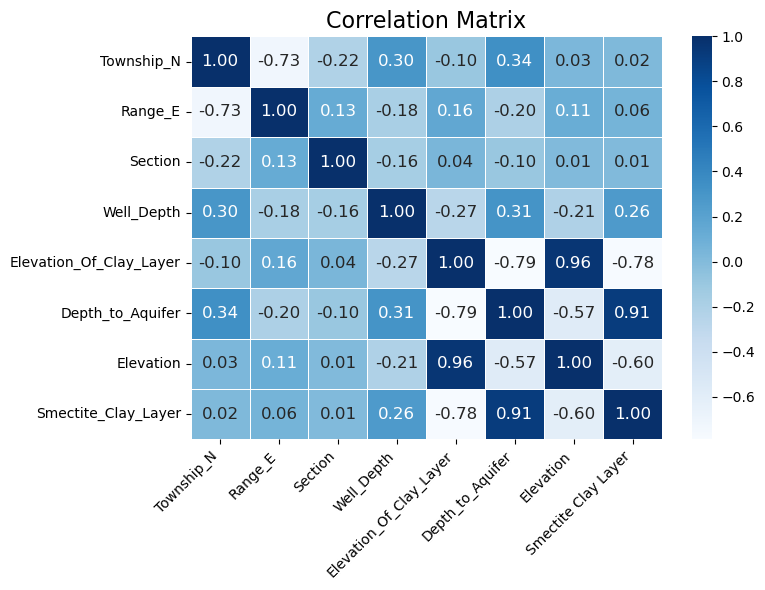

In [5]:
# Define the desired feature order
feature_order = ['Township_N', 'Range_E', 'Section', 'Well_Depth', 'Elevation_Of_Clay_Layer', 'Depth_to_Aquifer', 'Elevation', 'Smectite_Clay_Layer']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of the correlation matrix
correlation_matrix = data.corr()

# Reorder the rows and columns of the correlation matrix
correlation_matrix = correlation_matrix.reindex(index=feature_order, columns=feature_order)

# Customize the heatmap
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, annot_kws={"fontsize": 12}, ax=ax)

# Rotate and align the horizontal axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Modify the x-axis tick labels
x_tick_labels = heatmap.get_xticklabels()
x_tick_labels[-1] = 'Smectite Clay Layer'
heatmap.set_xticklabels(x_tick_labels)

# Rotate and align the vertical axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')

# Set the plot title and labels
ax.set_title('Correlation Matrix', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

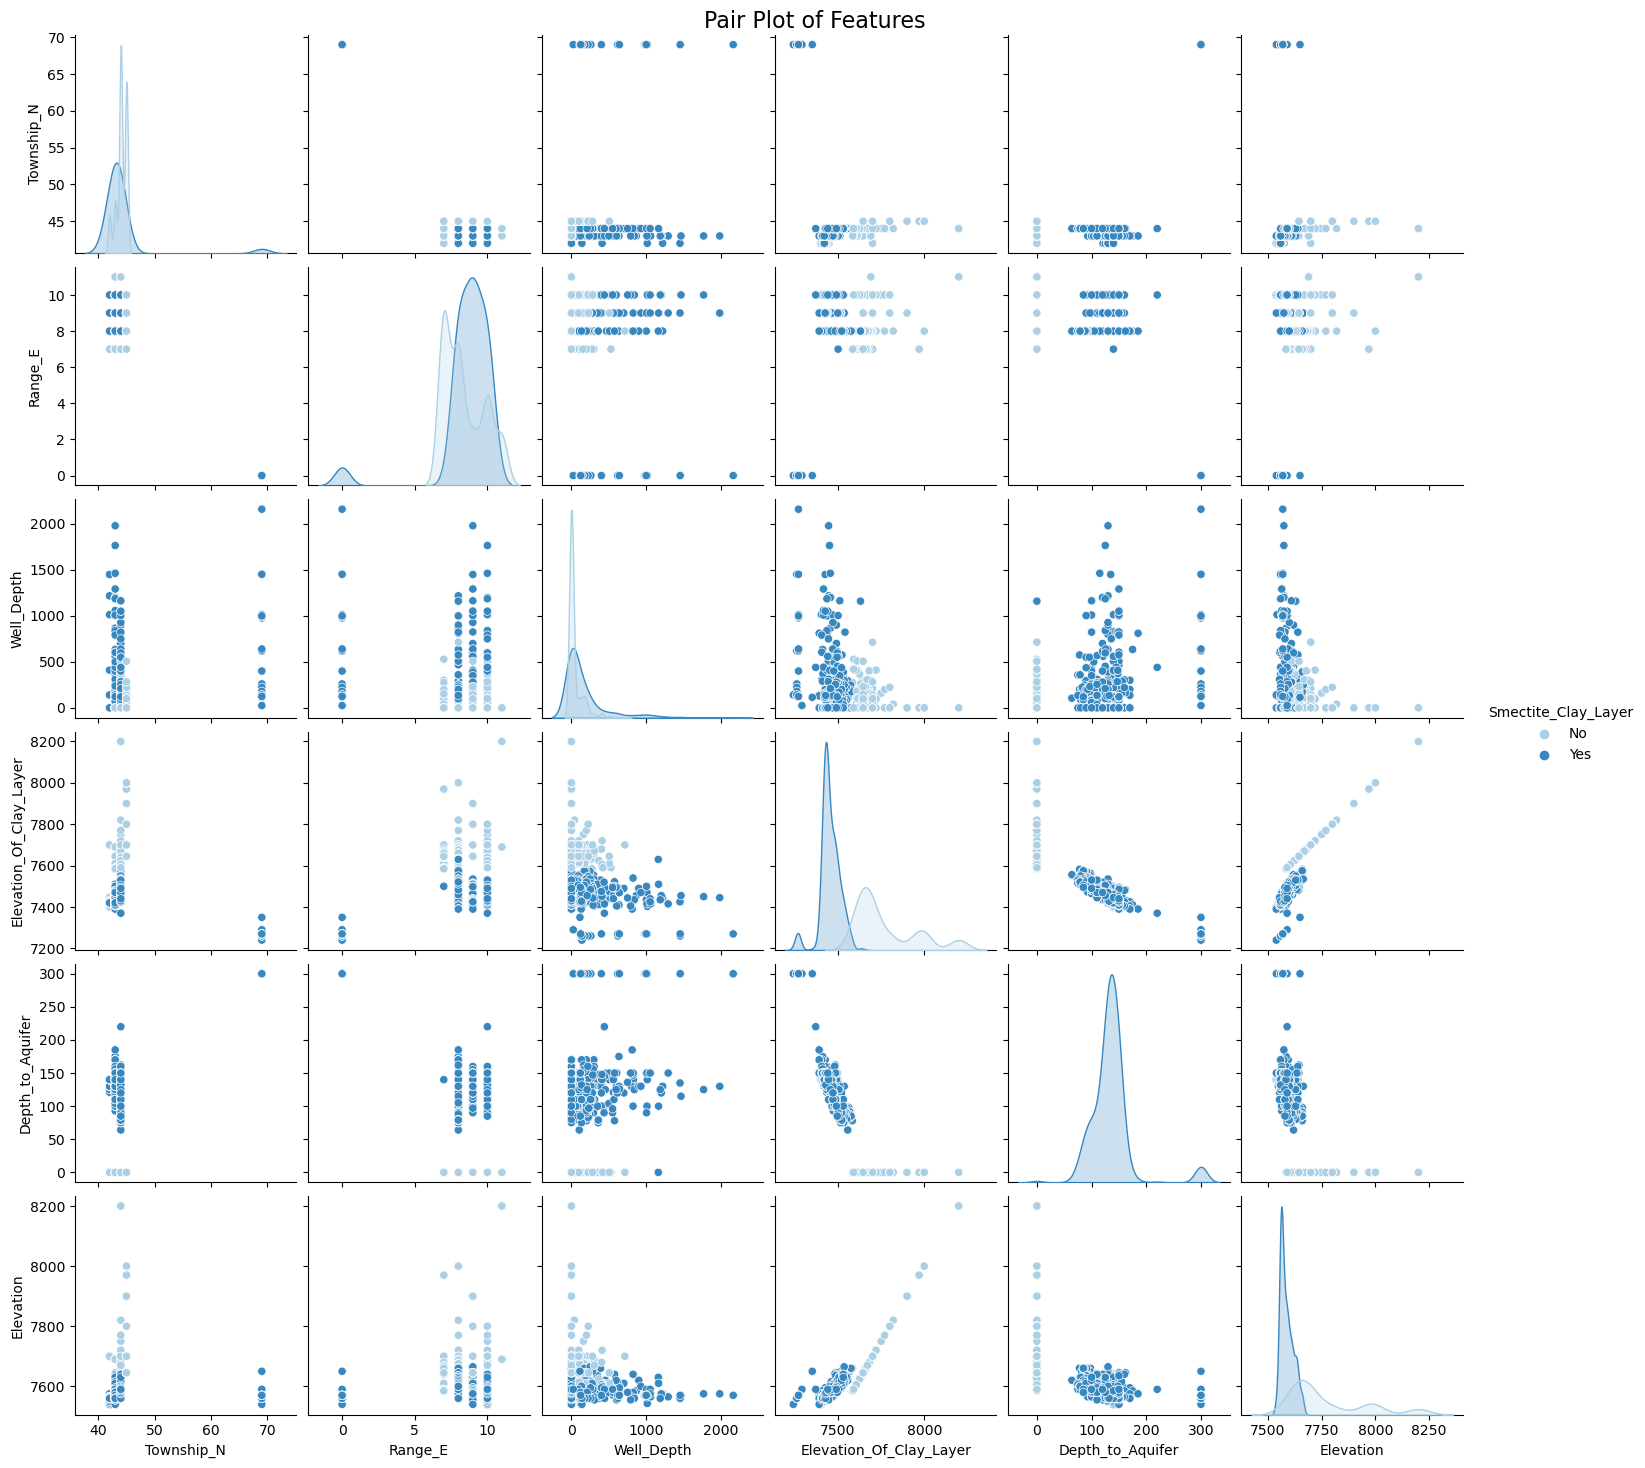

In [6]:
# Select the columns for the pair plot
pairplot_columns = ['Township_N', 'Range_E', 'Well_Depth', 'Elevation_Of_Clay_Layer', 'Depth_to_Aquifer', 'Elevation', 'Smectite_Clay_Layer']

# Subset the data with the selected columns
pairplot_data = data[pairplot_columns]

# Set the hue to 'Smectite_Clay_Layer' for color differentiation
pairplot_data['Smectite_Clay_Layer'] = pairplot_data['Smectite_Clay_Layer'].map({0: 'No', 1: 'Yes'})

# Create the pair plot with labeled axes and blue hue
pairplot = sns.pairplot(pairplot_data, hue='Smectite_Clay_Layer', palette='Blues')

# Add a title to the pair plot
pairplot.fig.suptitle('Pair Plot of Features', fontsize=16)

# Adjust the spacing between subplots to avoid overlap
pairplot.tight_layout()

# Display the plot
plt.show()

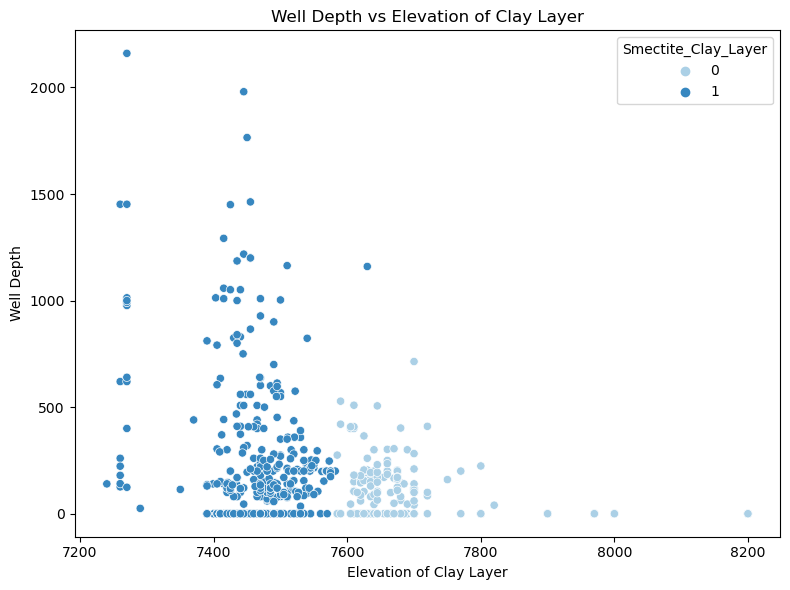

In [7]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Elevation_Of_Clay_Layer', y='Well_Depth', hue='Smectite_Clay_Layer', data=data, palette='Blues')
plt.xlabel('Elevation of Clay Layer')
plt.ylabel('Well Depth')
plt.title('Well Depth vs Elevation of Clay Layer')
plt.tight_layout()
plt.show()

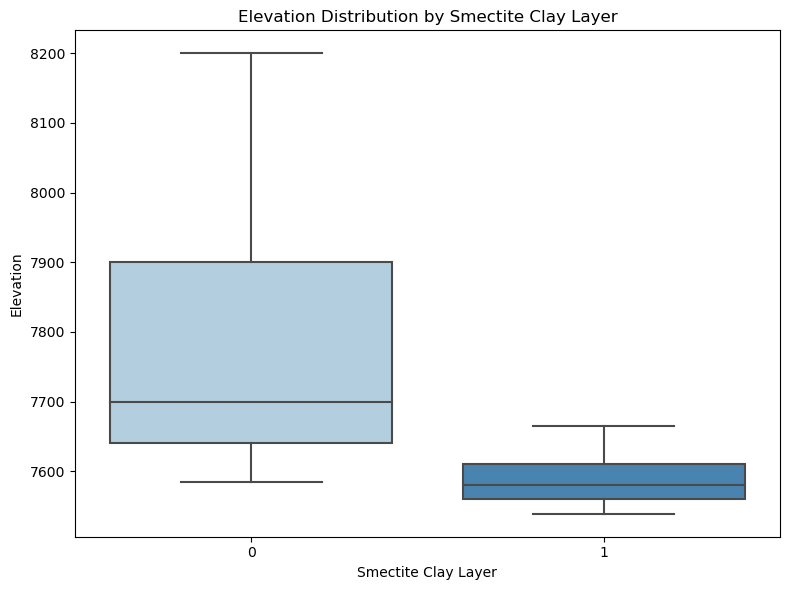

In [8]:
# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Smectite_Clay_Layer', y='Elevation', data=data.drop('Section', axis=1), palette='Blues')
plt.xlabel('Smectite Clay Layer')
plt.ylabel('Elevation')
plt.title('Elevation Distribution by Smectite Clay Layer')
plt.tight_layout()
plt.show()

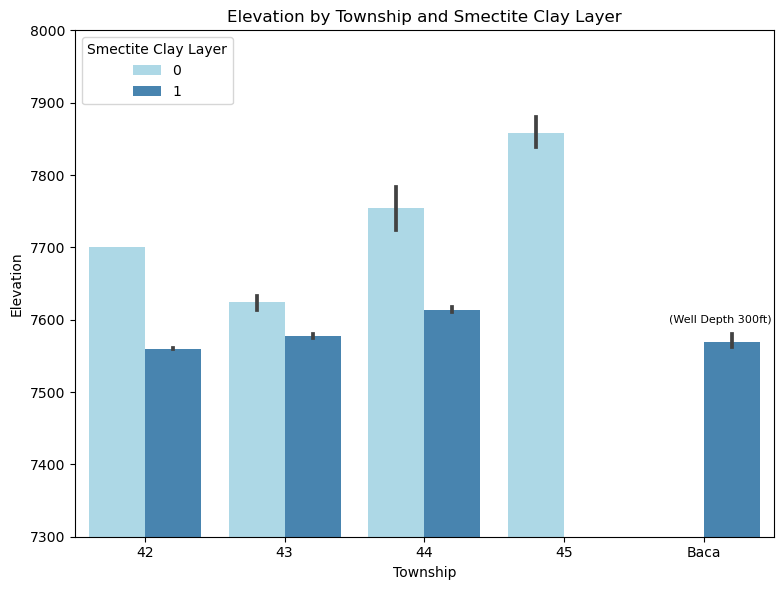

In [9]:
# Bar Chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Township_N', y='Elevation', hue='Smectite_Clay_Layer', data=data.drop('Section', axis=1), palette='Blues')
plt.xlabel('Township')
plt.ylabel('Elevation')
plt.title('Elevation by Township and Smectite Clay Layer')
plt.ylim(7300, 8000)  # Set the y-axis limits

# Modify the tick labels on the horizontal axis
xtick_labels = ax.get_xticklabels()
xtick_labels = ['Baca' if label.get_text() == '69' else label.get_text() for label in xtick_labels]
ax.set_xticklabels(xtick_labels)

# Customize the colors of the bars
bar_colors = ['darkblue' if label == 'Baca' else 'lightblue' for label in xtick_labels]
for patch, color in zip(ax.patches, bar_colors):
    patch.set_facecolor(color)

# Annotate the 'Baca' bar with 'Depth 300''
baca_index = xtick_labels.index('Baca')
baca_bar = ax.patches[baca_index]
x = baca_bar.get_x() + baca_bar.get_width()
y = 7600
ax.annotate('(Well Depth 300ft)', xy=(x, y), xytext=(-25, 0), textcoords='offset points', ha='left', va='center', fontsize=8)

# Move the legend to the upper left corner and add title
plt.legend(title='Smectite Clay Layer', loc='upper left')

plt.tight_layout()
plt.show()

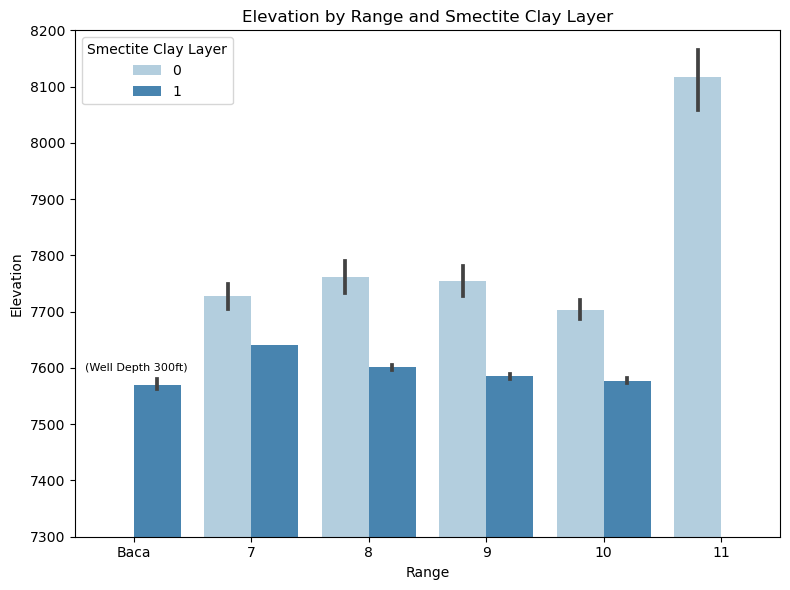

In [10]:
# Bar Chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Range_E', y='Elevation', hue='Smectite_Clay_Layer', data=data.drop('Section', axis=1), palette='Blues')
plt.xlabel('Range')
plt.ylabel('Elevation')
plt.title('Elevation by Range and Smectite Clay Layer')
plt.ylim(7300, 8200)  # Set the y-axis limits

# Modify the tick labels on the horizontal axis
xtick_labels = ax.get_xticklabels()
xtick_labels = ['Baca' if label.get_text() == '0' else label.get_text() for label in xtick_labels]
ax.set_xticklabels(xtick_labels)

# Annotate the 'Baca' bar with 'Depth 300ft'
baca_index = xtick_labels.index('Baca')
baca_bar = ax.patches[baca_index]
x = baca_bar.get_x() + baca_bar.get_width()
y = 7600
ax.annotate('(Well Depth 300ft)', xy=(x, y), xytext=(-35, 0), textcoords='offset points', ha='left', va='center', fontsize=8)

# Move the legend to the upper left corner and add title
plt.legend(title='Smectite Clay Layer', loc='upper left')

plt.tight_layout()
plt.show()

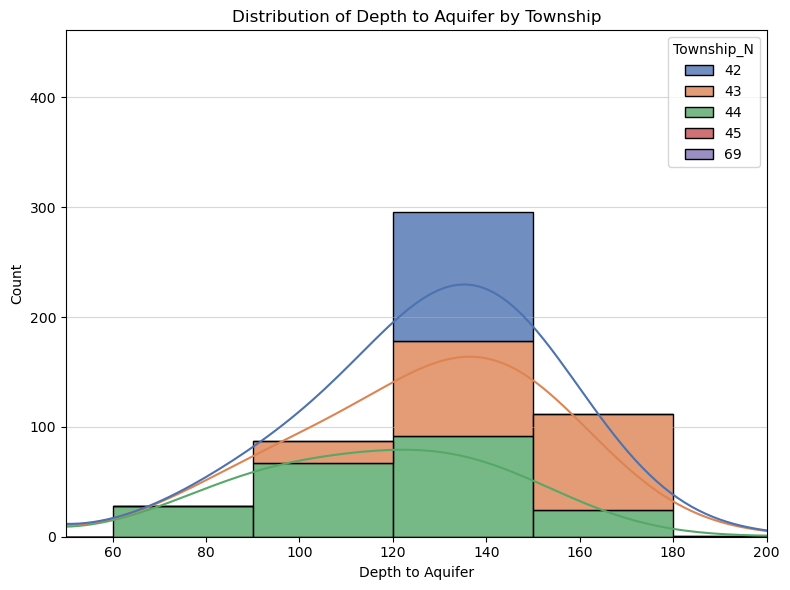

In [11]:
# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(data, x='Depth_to_Aquifer', bins=10, kde=True, hue='Township_N', palette='deep', multiple='stack', alpha=0.8, edgecolor='black')
plt.xlabel('Depth to Aquifer')
plt.ylabel('Count')
plt.title('Distribution of Depth to Aquifer by Township')
plt.xlim(50, 200)  # Set the horizontal axis limits
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

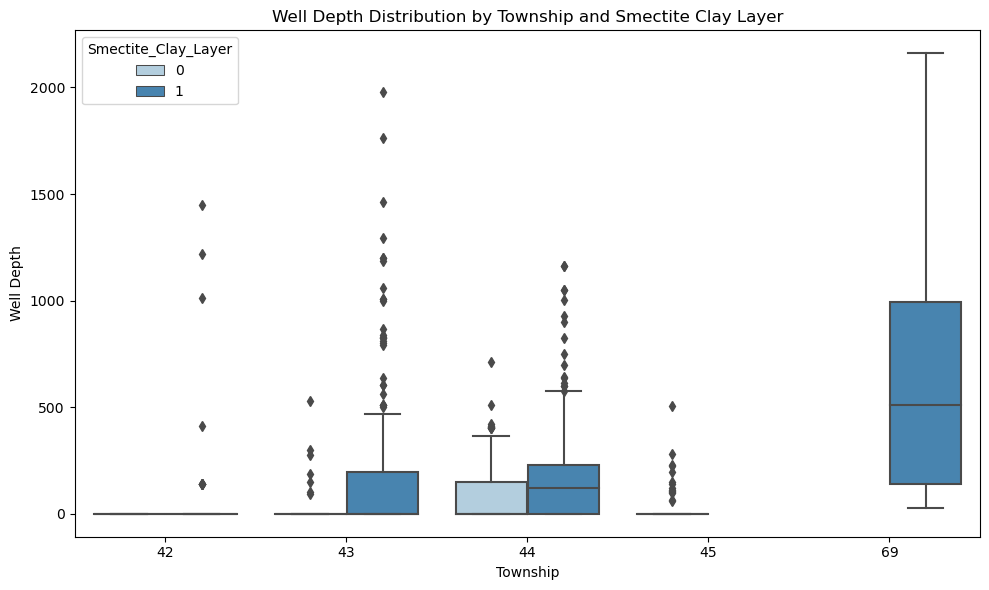

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Township_N', y='Well_Depth', hue='Smectite_Clay_Layer', data=data, palette='Blues')
plt.xlabel('Township')
plt.ylabel('Well Depth')
plt.title('Well Depth Distribution by Township and Smectite Clay Layer')
plt.tight_layout()
plt.show()

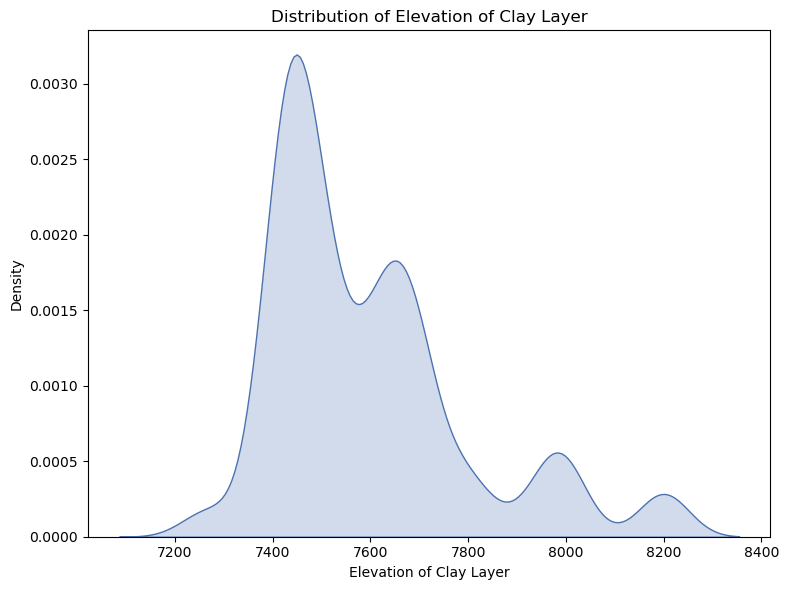

In [13]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data['Elevation_Of_Clay_Layer'], shade=True, color=(0.298, 0.447, 0.690))
plt.xlabel('Elevation of Clay Layer')
plt.ylabel('Density')
plt.title('Distribution of Elevation of Clay Layer')
plt.tight_layout()
plt.show()

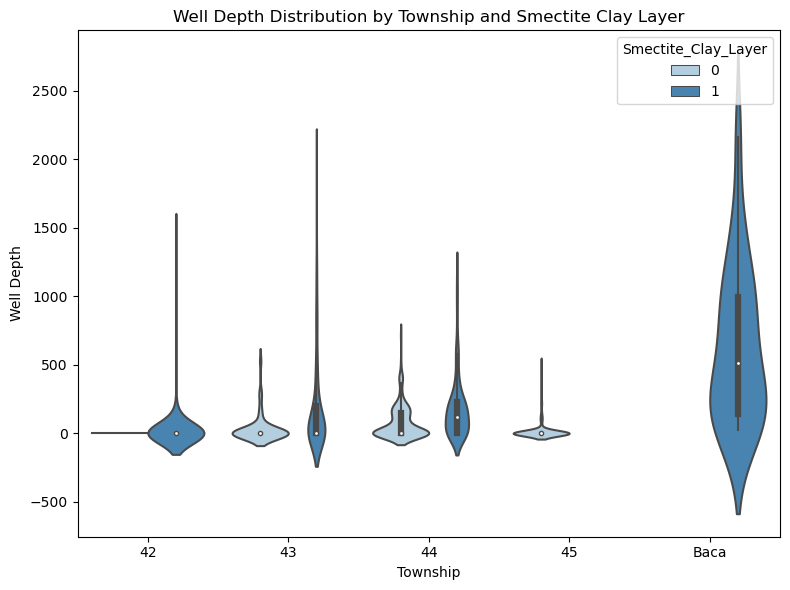

In [14]:
# Violin Plot
plt.figure(figsize=(8, 6))
violin_plot = sns.violinplot(x='Township_N', y='Well_Depth', hue='Smectite_Clay_Layer', data=data.drop('Section', axis=1), palette='Blues')
plt.xlabel('Township')
plt.ylabel('Well Depth')
plt.title('Well Depth Distribution by Township and Smectite Clay Layer')
plt.tight_layout()

# Replace "69" with "Baca" in the x-axis labels
township_labels = violin_plot.get_xticklabels()
township_labels = [label.get_text().replace('69', 'Baca') for label in township_labels]
violin_plot.set_xticklabels(township_labels)

plt.show()

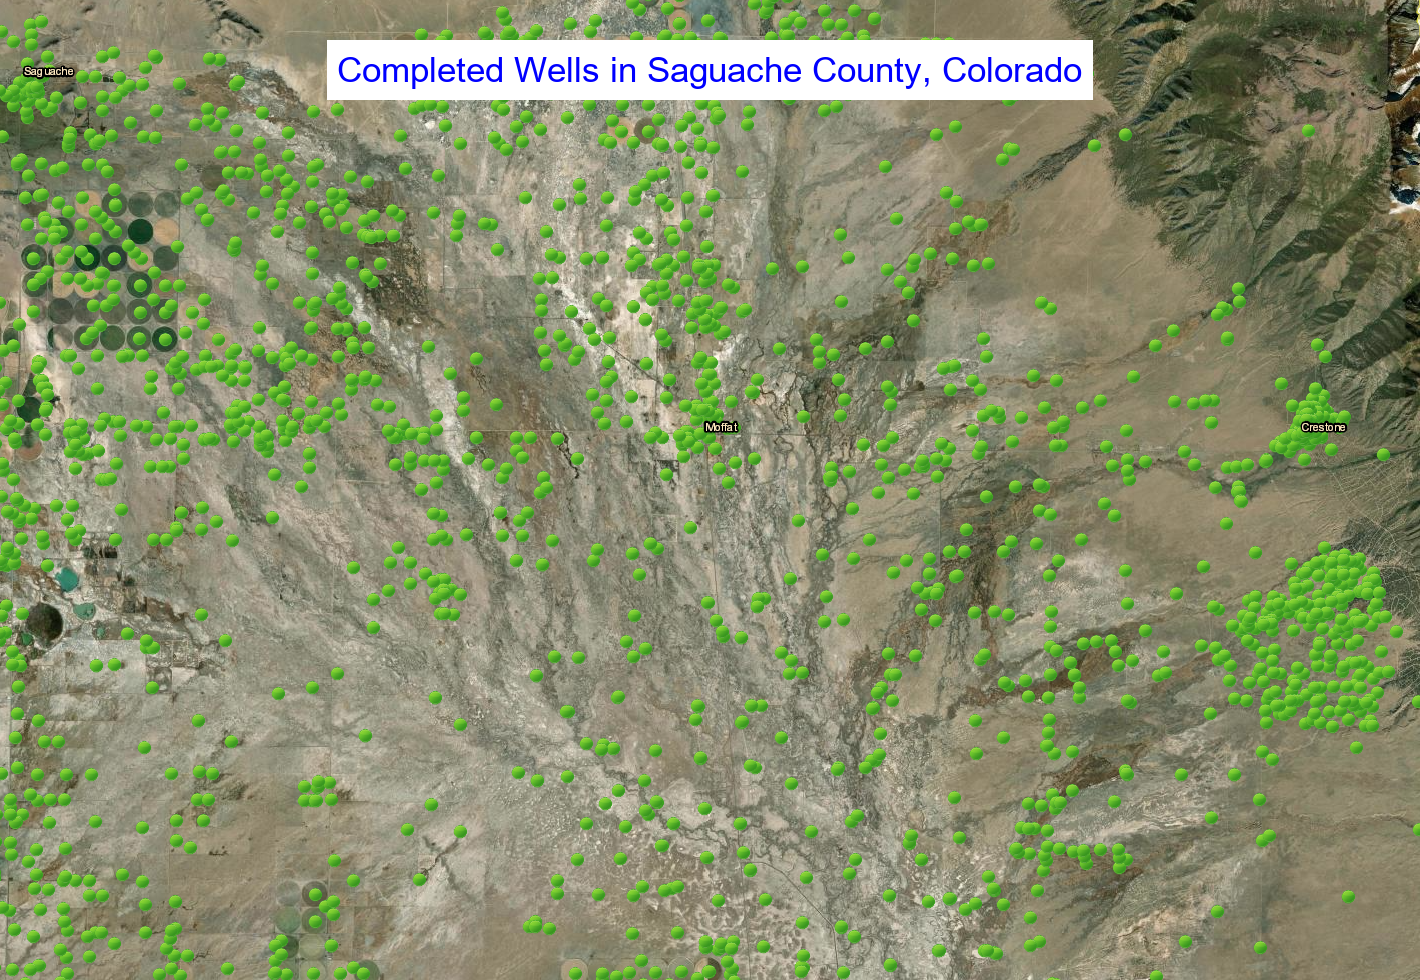

In [15]:
# Open the image
image_path2 = 'C:/Users/newmy/Desktop/WaterProj/iWells.png'
image2 = Image.open(image_path2)

# Define the font and font size
font = ImageFont.truetype("arial.ttf", size=35)

# Define the text to be annotated
text = "Completed Wells in Saguache County, Colorado"

# Calculate the position to place the text
text_width, text_height = font.getsize(text)
x = (image2.width - text_width) // 2
y = 50

# Set the color of the highlight bar
highlight_color = (255, 255, 255)  #  color

# Calculate the dimensions of the highlight bar
highlight_width = text_width + 20
highlight_height = text_height + 20
highlight_x = (image2.width - highlight_width) // 2
highlight_y = y - 10

# Create an ImageDraw object
draw2 = ImageDraw.Draw(image2)

# Draw the highlight bar
draw2.rectangle((highlight_x, highlight_y, highlight_x + highlight_width, highlight_y + highlight_height),
                fill=highlight_color)

# Set the color of the text
text_color = (0, 0, 255)  # Blue color

# Annotate the image with the text
draw2.text((x, y), text, fill=text_color, font=font)

# Save the annotated image in PNG format
annotated_image_path2 = 'C:/Users/newmy/Desktop/WaterProj/annotated_image2.png'
image2.save(annotated_image_path2, format='PNG')

# Display the annotated image
display(DisplayImage(filename=annotated_image_path2))

# Build, Test and Visualize the Model Performance

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Read the data
data = pd.read_csv('C:/Users/newmy/Desktop/WaterProj/dWaterProjDataB.csv')

# Separate the input features (X) and the target label (y)
X = data.drop(columns=['Smectite_Clay_Layer'])
y = data['Smectite_Clay_Layer']

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Perform any necessary preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build the deep learning model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer with a smaller learning rate
optimizer = Adam(learning_rate = 0.0001)  # Set the learning rate to 0.0001

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

# Train the model with Early Stopping
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Calculate test accuracy as a percentage
test_accuracy_percentage = test_accuracy * 100
print('Test Accuracy (Percentage): {:.2f}%'.format(test_accuracy_percentage))

# Make predictions
predictions = model.predict(X_test_scaled)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

Epoch 1/50
23/23 [==============================] - 1s 6ms/step - loss: 0.6943 - accuracy: 0.4649 - val_loss: 0.6898 - val_accuracy: 0.4286
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.6447 - val_loss: 0.6676 - val_accuracy: 0.8175
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6545 - accuracy: 0.8287 - val_loss: 0.6465 - val_accuracy: 0.8889
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6358 - accuracy: 0.8680 - val_loss: 0.6240 - val_accuracy: 0.9127
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.8933 - val_loss: 0.5982 - val_accuracy: 0.9286
Epoch 6/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5896 - accuracy: 0.8919 - val_loss: 0.5703 - val_accuracy: 0.9286
Epoch 7/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.8904 - val_loss: 0.5419 - val_accuracy: 0.9206
Epoch 8/50
23/23 [==

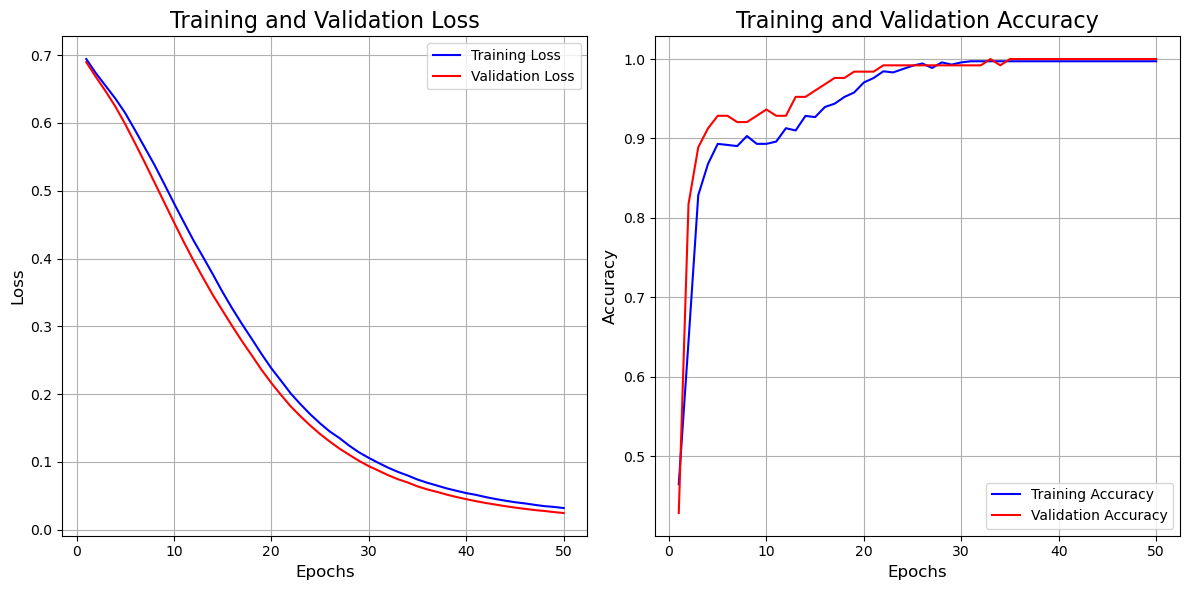

In [17]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'b', label='Training Loss')  # Truncate the train_loss array
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')  # Truncate the val_loss array
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(loc='upper right')

# Plot training and validation accuracy
ax2.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(loc='lower right')

plt.subplots_adjust(wspace=0.3)
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 836us/step


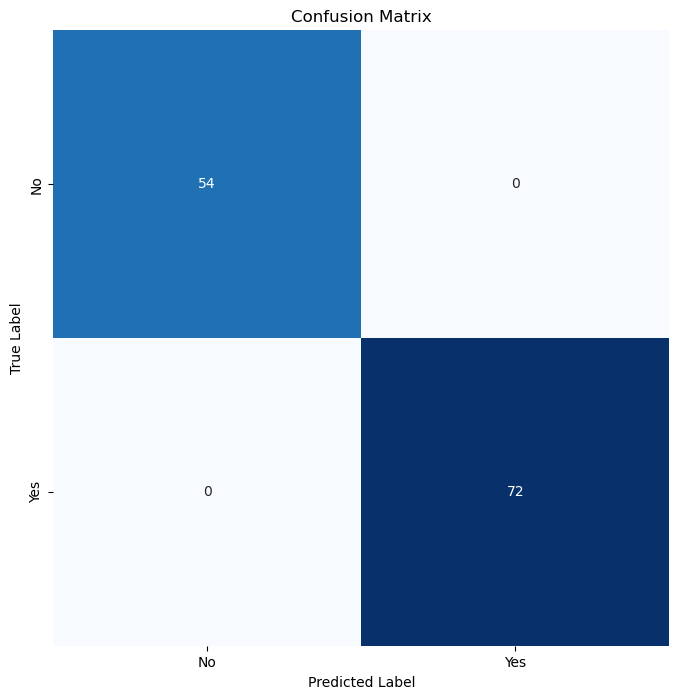

In [18]:
# Generate predictions on the validation set
validation_predictions = model.predict(X_val_scaled)
predicted_labels = [1 if pred > 0.5 else 0 for pred in validation_predictions]

# Compute the confusion matrix
confusion = confusion_matrix(y_val, predicted_labels)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Customize the heatmap
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', cbar=False, square=True,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax)

# Add labels and title
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

In [19]:
from tabulate import tabulate

# Make predictions
predictions = model.predict(X_test_scaled)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Create a DataFrame with elevation and predictions
elevation_predictions = pd.DataFrame({'Elevation of Clay Layer': X_test['Elevation'], 'Predicted Label': predicted_labels})

# Filter the DataFrame based on predictions
predictions_1 = elevation_predictions[elevation_predictions['Predicted Label'] == 1]
predictions_0 = elevation_predictions[elevation_predictions['Predicted Label'] == 0]

# Display the tables
if not predictions_1.empty:
    print("Predictions with Elevation for Predicted Label 1:")
    print(tabulate(predictions_1, headers='keys', tablefmt='psql'))
else:
    print("No Predictions with Elevation for Predicted Label 1")

if not predictions_0.empty:
    print("Elevation for Predicted Label 0:")
    print(tabulate(predictions_0[['Elevation of Clay Layer']], headers='keys', tablefmt='psql'))
else:
    print("No Elevation for Predicted Label 0")

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

    # Calculate the average elevation of the predicted values
average_elevation = np.mean(elevation_predictions['Elevation of Clay Layer'])

# Calculate the average elevation for predicted values of 1
average_elevation_1 = np.mean(predictions_1['Elevation of Clay Layer'])
print(f"Average Elevation for Predicted Label Smectite Clay Layer: {average_elevation_1:.2f}")

# Calculate the average elevation for predicted values of 0
average_elevation_0 = np.mean(predictions_0['Elevation of Clay Layer'])
print(f"Average Elevation for Predicted Label No Smectite Clay Layer: {average_elevation_0:.2f}")

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

5/5 [==============================] - 0s 766us/step
Predictions with Elevation for Predicted Label 1:
+-----+---------------------------+-------------------+
|     |   Elevation of Clay Layer |   Predicted Label |
|-----+---------------------------+-------------------|
| 613 |                      7610 |                 1 |
| 731 |                      7605 |                 1 |
| 275 |                      7570 |                 1 |
| 582 |                      7620 |                 1 |
| 299 |                      7570 |                 1 |
| 351 |                      7560 |                 1 |
| 594 |                      7635 |                 1 |
| 652 |                      7590 |                 1 |
| 294 |                      7565 |                 1 |
|  66 |                      7565 |                 1 |
| 377 |                      7580 |                 1 |
| 755 |                      7580 |                 1 |
| 107 |                      7560 |                 1 |
|

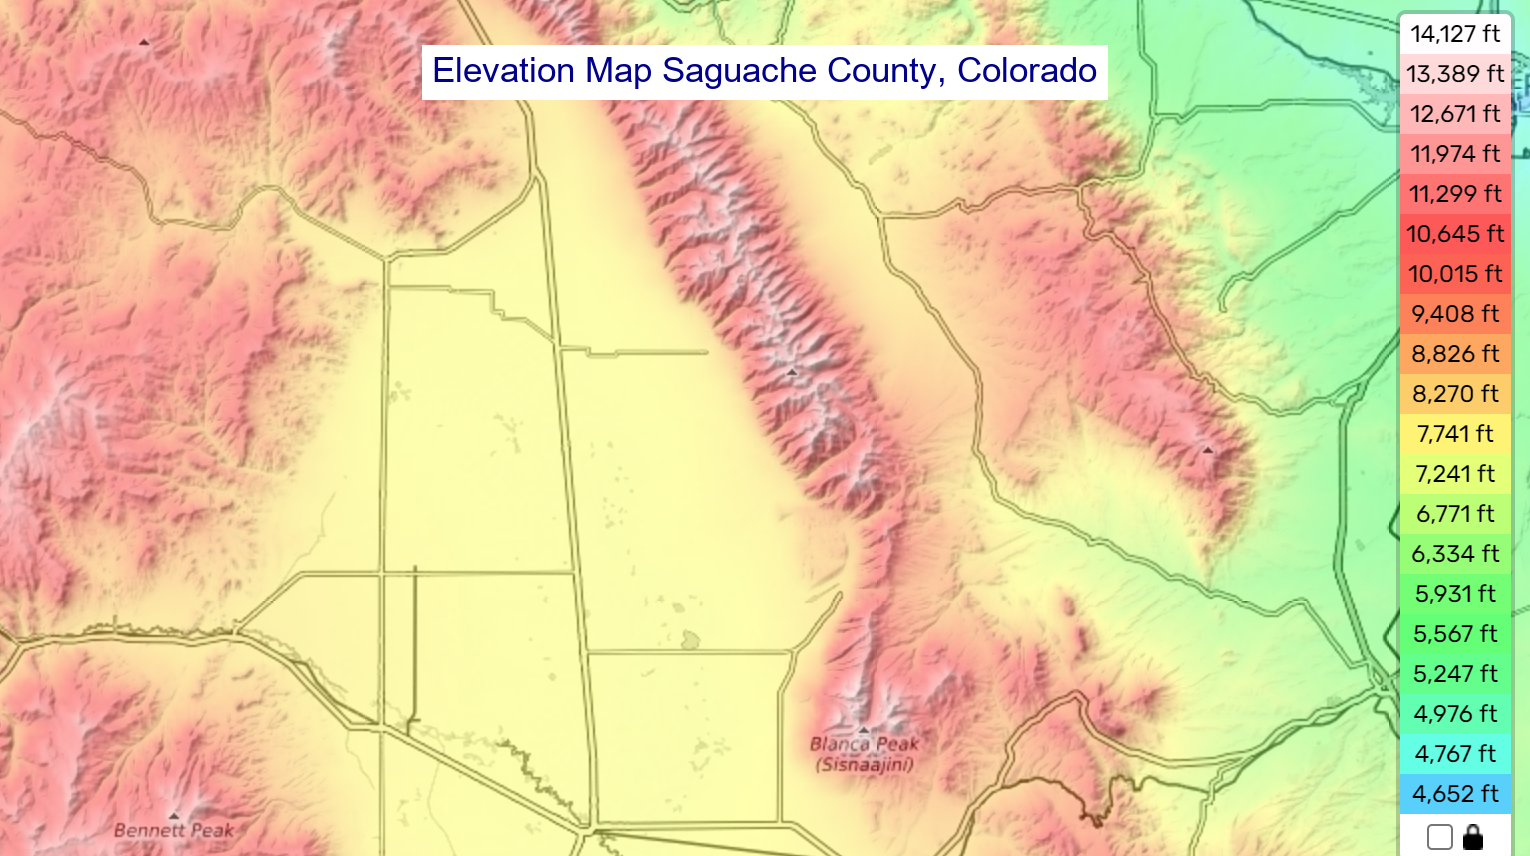

In [20]:
# Open the image
image_path3 = 'C:/Users/newmy/Desktop/WaterProj/iElevation.png'
image3 = Image.open(image_path3)

# Create an ImageDraw object
draw3 = ImageDraw.Draw(image3)

# Define the font and font size
font = ImageFont.truetype("arial.ttf", size=35)

# Define the text to be annotated
text = "Elevation Map Saguache County, Colorado"

# Calculate the position to place the text
text_width, text_height = draw3.textsize(text, font=font)
x = (image3.width - text_width) // 2
y = 50  # Place the annotation at the top

# Set the color of the text
text_color = (0, 0, 139)  # Dark blue color

# Set the size of the highlighter bar
highlighter_height = text_height + 10

# Calculate the coordinates for the highlighter bar
bar_x1 = x - 10
bar_y1 = y - 5
bar_x2 = x + text_width + 10
bar_y2 = y + highlighter_height

# Draw the white highlighter bar
highlighter_color = (255, 255, 255)  # White color
draw3.rectangle([(bar_x1, bar_y1), (bar_x2, bar_y2)], fill=highlighter_color)

# Annotate the image with the text
draw3.text((x, y), text, fill=text_color, font=font)

# Save the annotated image in PNG format
annotated_image_path3 = 'C:/Users/newmy/Desktop/WaterProj/annotated_image3.png'
image3.save(annotated_image_path3, format='PNG')

# Display the annotated image
display(DisplayImage(filename=annotated_image_path3))

# Present User Interface for Predictions

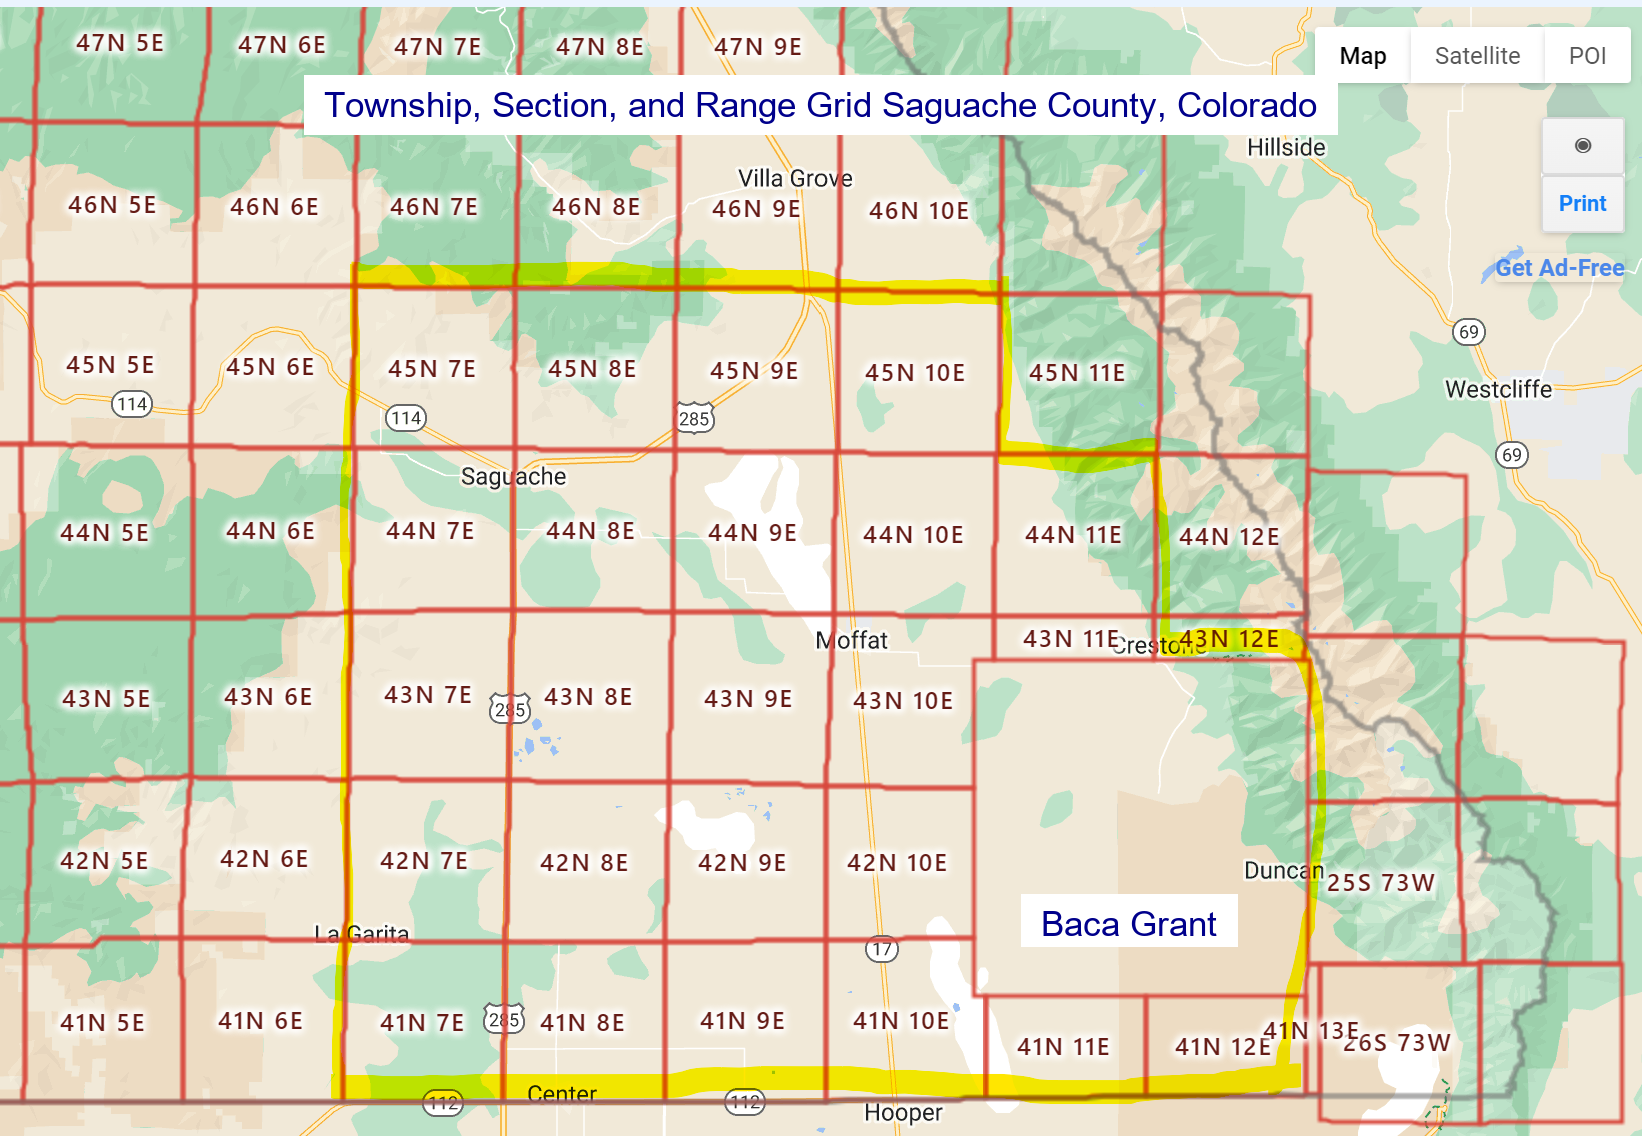

In [21]:
# Open the image
image_path4 = 'C:/Users/newmy/Desktop/WaterProj/iSTR.png'
image4 = Image.open(image_path4)

# Create an ImageDraw object
draw4 = ImageDraw.Draw(image4)

# Define the font and font size
font = ImageFont.truetype("arial.ttf", size=35)

# Define the text to be annotated
text_top = "Township, Section, and Range Grid Saguache County, Colorado"
text_bottom = "Baca Grant"

# Calculate the position to place the text
text_top_width, text_top_height = draw4.textsize(text_top, font=font)
text_bottom_width, text_bottom_height = draw4.textsize(text_bottom, font=font)
x_top = (image4.width - text_top_width) // 2
y_top = 50 + 10 + 25  # Place the top annotation at the desired position
x_bottom = image4.width - text_bottom_width - 425  # Place the bottom annotation on the right side
y_bottom = image4.height - text_bottom_height - 200  # Place the bottom annotation on the bottom right corner

# Set the color of the text
text_color = (0, 0, 139)  # Dark blue color

# Calculate the coordinates for the top highlighter bar
padding_x = 20
padding_y = 10
highlighter_top_x = x_top - padding_x
highlighter_top_y = y_top - padding_y
highlighter_top_width = text_top_width + 2 * padding_x
highlighter_top_height = text_top_height + 2 * padding_y

# Calculate the coordinates for the bottom highlighter bar
highlighter_bottom_x = x_bottom - padding_x
highlighter_bottom_y = y_bottom - padding_y
highlighter_bottom_width = text_bottom_width + 2 * padding_x
highlighter_bottom_height = text_bottom_height + 2 * padding_y

# Draw the white highlighter bars
highlighter_color = (255, 255, 255)  # White color
draw4.rectangle((highlighter_top_x, highlighter_top_y, highlighter_top_x + highlighter_top_width, highlighter_top_y + highlighter_top_height), fill=highlighter_color)
draw4.rectangle((highlighter_bottom_x, highlighter_bottom_y, highlighter_bottom_x + highlighter_bottom_width, highlighter_bottom_y + highlighter_bottom_height), fill=highlighter_color)

# Annotate the image with the top text
draw4.text((x_top, y_top), text_top, fill=text_color, font=font)

# Annotate the image with the bottom text
draw4.text((x_bottom, y_bottom), text_bottom, fill=text_color, font=font)

# Save the annotated image in PNG format
annotated_image_path4 = 'C:/Users/newmy/Desktop/WaterProj/annotated_image4.png'
image4.save(annotated_image_path4, format='PNG')

# Display the annotated image
display(DisplayImage(filename=annotated_image_path4))

In [ ]:
while True:
    # Prompt the user to enter section, township, and range values
    township = int(input("Enter the township: "))
    range_value = int(input("Enter the range: "))
    section = int(input("Enter the section: "))

    # Filter the data based on user input
    indices = (data['Township_N'] == township) & (data['Range_E'] == range_value) & (data['Section'] == section)
    user_data = data.loc[indices]

    if len(user_data) > 0:
        # Remove the unnecessary column from user data
        user_data = user_data.drop(columns=['Smectite_Clay_Layer'])

        # Scale the user input using the same scaler used for training data
        user_data_scaled = scaler.transform(user_data)

        # Make predictions on the user input
        predictions = model.predict(user_data_scaled)
        predicted_label = [1 if pred > 0.5 else 0 for pred in predictions]

        if predicted_label[0] == 1:
            # Get the corresponding elevation of the clay layer from the original dataset
            elevation_of_clay_layer = data.loc[indices, 'Elevation_Of_Clay_Layer']

            if len(elevation_of_clay_layer) > 1:
                # Calculate the average elevation
                average_elevation = elevation_of_clay_layer.mean()

                # Display the average elevation of the clay layer
                print("Smectite clay layer likely at elevation:", average_elevation, "ft.")
            else:
                # Display the elevation of the clay layer
                print("Smectite clay layer likely at elevation:", elevation_of_clay_layer.item(), "ft.")
        else:
            print("No smectite clay layer predicted.")
    else:
        print("No matching data found for the given township, range, and section.")

    # Prompt the user for the next action
    choice = input("Enter '1' to re-enter data or any other key to quit: ")
    if choice != '1':
        break

Enter the township: 44
Enter the range: 8
Enter the section: 13
1/1 [==============================] - 0s 12ms/step
No smectite clay layer predicted.
Enter '1' to re-enter data or any other key to quit: 1
Enter the township: 44
Enter the range: 9
Enter the section: 13
1/1 [==============================] - 0s 12ms/step
Smectite clay layer likely at elevation: 7460 ft.


# Conclusion

The final model used in the Saguache County Water Study is a deep learning model with a specific architecture. The architecture of the deep learning model consists of multiple layers designed to process the input data and make predictions. Here is a description of each layer in the model:

Conv1D Layer: This layer performs 1D convolution on the input data. It has 32 filters and a kernel size of 3. The activation function used is ReLU, which introduces non-linearity to the model. The input shape is determined based on the number of features in the scaled training data.

MaxPooling1D Layer: This layer performs max pooling operation to downsample the output from the previous convolutional layer. It uses a pool size of 2, which means it takes the maximum value within a sliding window of size 2.

Flatten Layer: This layer flattens the output from the previous layer into a one-dimensional vector. It reshapes the data from a 2D representation to a 1D representation, preparing it for the subsequent fully connected layers.

Dense Layers: Two dense layers follow the flatten layer. The first dense layer has 128 units with a ReLU activation function, which helps to capture complex relationships in the data. The second dense layer has 64 units, also using the ReLU activation function.

Output Layer: The final dense layer consists of a single unit with a sigmoid activation function. It produces the output prediction for the presence of the smectite clay layer. The sigmoid activation function squeezes the output between 0 and 1, representing the probability of the positive class (presence of the clay layer).

The model utilizes the Adam optimizer with a learning rate of 0.0001 and is compiled with the binary cross-entropy loss function, which is suitable for binary classification tasks. Early stopping is employed as a callback, with a patience of 3 epochs and monitoring the validation loss.

The model architecture leverages convolutional layers to capture local patterns and spatial dependencies in the input data, followed by dense layers to learn higher-level representations and make predictions. This combination of convolutional and dense layers enables the model to effectively process the well completion report data and predict the presence of the smectite clay layer.

After training the model, it is evaluated on the test set to assess its performance. The test loss and test accuracy are calculated and displayed. Additionally, the test accuracy is also presented as a percentage for better interpretation. The accuracy of the model is illustrated by the Confusion Matrix where all test data was correctly identified.

To utilize the trained model, users have the option to input Township, Range, and Section values. These values are used as input to the model, which predicts the presence of the smectite clay layer at the specified location. If the model predicts the presence of the clay layer, the average elevation of the layer at that location is returned as an output.